In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import GraphHelpers as GH
import ETFunctions as et
import MathsUtilities as MUte

## Bring in the data needed

### Met Data

In [5]:
MetData = pd.read_pickle('../BroadFieldsMet.pkl')
DaylightIndex = MetData.IncomingRadnMJ.where(MetData.IncomingRadnMJ>0.002)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.tolist()
MetData.loc[:,'satVP'] = [et.saturated_vapor_pressure(MetData.loc[x,'AirTemperature'])/10 for x in MetData.index]
MetData.loc[:,'VP'] = [MetData.loc[x,'satVP']*MetData.loc[x,'RelativeHumidity']/100 for x in MetData.index]
MetData.loc[:,'VPD'] = MetData.satVP.subtract(MetData.VP)

DailyMet = MetData.IncomingRadnMJ.resample('D').sum()
DailyMet = pd.DataFrame(index=DailyMet.index,data=DailyMet.values,columns=['Radn'])
DailyMet.loc[:,'Temp'] = MetData.AirTemperature.resample('D').mean()
DailyMet.loc[:,'RH'] = MetData.RelativeHumidity.resample('D').mean()
DailyMet.loc[:,'VPD'] = MetData.loc[DaylightIndex,'VPD'].resample('D').mean()
MinVPD = 0.1
DailyMet.loc[:,'VP'] = MetData.VP.resample('D').mean()
DailyMet.loc[:,'VPD'] = DailyMet.loc[:,'VPD'].where(DailyMet.loc[:,'VPD']>MinVPD,MinVPD)
DailyMet.loc[:,'Wind'] = MetData.Windspeed.resample('D').mean()
DailyMet.loc[:,'Rainfall'] = MetData.loc[:,'Rainfall'].resample('D').sum()
DailyMet.loc[:,'PET'] = [et.PenmanEO(DailyMet.loc[x,'Radn'],
                                    DailyMet.loc[x,'Temp'],
                                    DailyMet.loc[x,'Wind'],
                                    DailyMet.loc[x,'VP'],
                                    'Total') for x in DailyMet.index]

AccumPET = DailyMet.PET.cumsum()

### Soil Water and Temperature Data

In [6]:
RTData = pd.read_csv('C:\\GitHubRepos\\ApsimX\\Tests\\Validation\\SoilWater\\a_block_obs_soilwater.txt',
                     delim_whitespace=True,skiprows=[1])
RTData.set_index(['SimulationName','Clock.Today'],inplace=True)

In [7]:
ABlock = pd.read_csv('C:\\GitHubRepos\\CropWaterAnalysis\\Evaporation\\AblockResiduesSWC.dat',
            skiprows=[0,2,3])
ABlock.set_index(['TIMESTAMP'],inplace=True)
ABlock.drop(['RECORD'],inplace=True,axis=1)
ABlock.columns.name = 'ColumnID' 
ABlockIndex = pd.read_excel('C:\\GitHubRepos\\CropWaterAnalysis\\Evaporation\\DataIndex.xlsx')
ABlockIndex.set_index('ColumnID',inplace=True)
JoinIndex = ABlockIndex.transpose().loc[('Treatment','Depth','Block'),:]

In [8]:
Intrum = pd.concat([JoinIndex,ABlock])
Intrum = Intrum.transpose()
Intrum.set_index(['Treatment','Depth','Block'],inplace=True,drop=True)
ResidueExptSWC = Intrum.transpose().iloc[:,:56].copy()
GH.SortFrame(ResidueExptSWC)
ResidueExptSWC.index = pd.to_datetime(ResidueExptSWC.index)
for col in ResidueExptSWC.columns:
    ResidueExptSWC.loc[:,col] = pd.to_numeric(ResidueExptSWC.loc[:,col])
SoilTemp = pd.DataFrame(index = pd.to_datetime(Intrum.transpose().index),columns = [1,2,3])
for col in [0,1,2]:
    SoilTemp.iloc[:,col] = pd.to_numeric(Intrum.loc['SoilTemp',:].transpose().iloc[:,:3].iloc[:,col])
SoilTemp.columns.name='Depth'

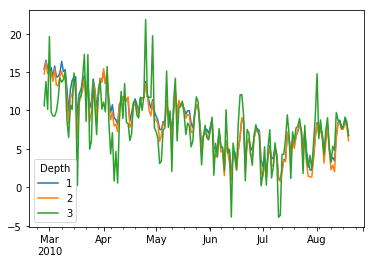

In [9]:
SoilTemp.loc[SoilTemp.index.hour==23].resample('D').mean().plot()

## Soil temperatures at midnight are all below 20 degres.  CS616 temperature sensitivity is neglegable below 20 (Lab temp response measured in soils incubators) so if we use soil water content at midnight to calculate daily deltas there is no need to apply temperature correction.

## Look at means soil water patterns

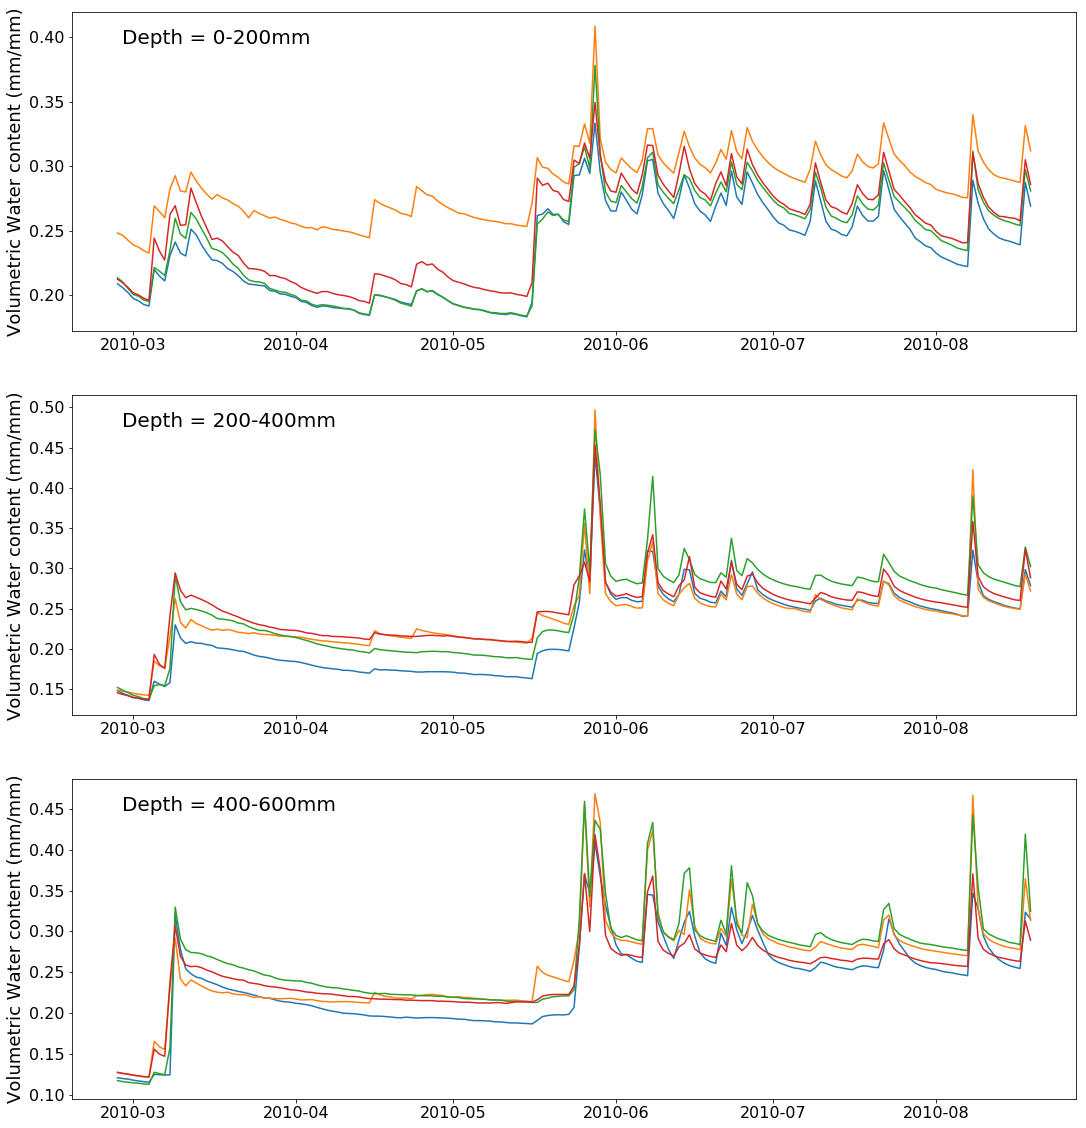

In [11]:
#Take SWC at midnight to represent end of day soil water content
DailySWC = ResidueExptSWC.loc[ResidueExptSWC.index.hour==23].resample('D').mean()

Treatments = ResidueExptSWC.columns.get_level_values(0).drop_duplicates().values
Depths = ResidueExptSWC.columns.get_level_values(1).drop_duplicates().values
DepthLabels = pd.DataFrame(index=Depths,data=['0-200mm','200-400mm','400-600mm'],columns=['Label'])
Graph = plt.figure(figsize=(18,20))
pos=1
for D in Depths:
    ax = Graph.add_subplot(3,1,pos)
    for T in Treatments:
        plt.plot(DailySWC.loc[:,(T,D)].mean(axis=1))
    lab = 'Depth = ' + DepthLabels.loc[D,'Label']
    plt.text(0.05,0.9,lab,transform=ax.transAxes, fontsize=20)
    plt.tick_params(labelsize=16)
    plt.ylabel('Volumetric Water content (mm/mm)',fontsize=18)
    pos+=1


## Pretty small deltas in the lower two depths so lets determine evaporation from top 200 mm only

In [12]:
SW20 = DailySWC.loc[:,(slice(None),1)].groupby(level='Treatment',axis=1).mean()*200
DeltaSW20 = SW20.diff()

(-10, 2)

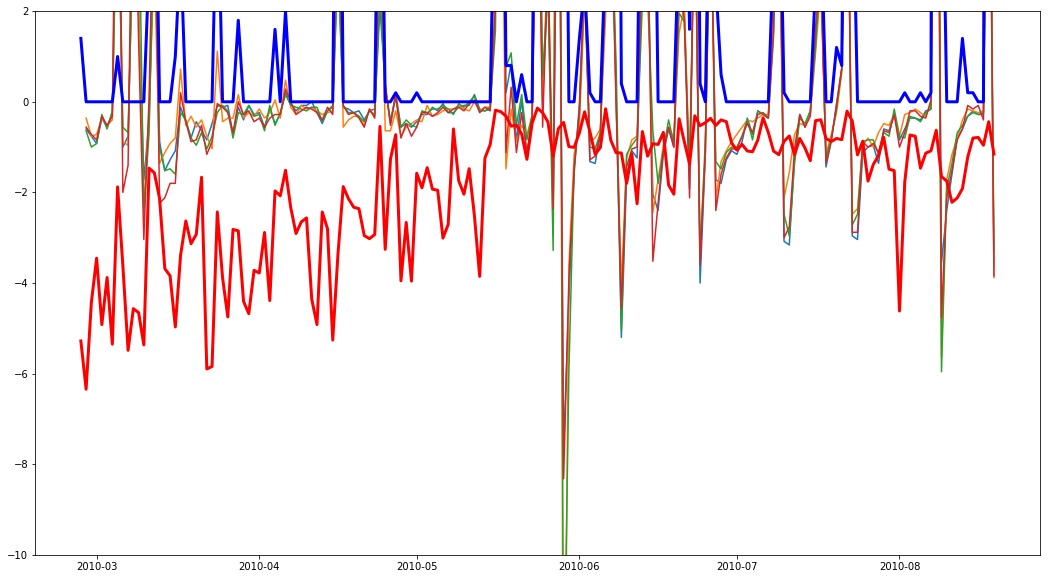

In [13]:
Graph = plt.figure(figsize=(18,10))
plt.plot(DeltaSW20)
plt.plot(DailyMet.Rainfall.loc[SW20.index],'-b',lw=3)
plt.plot(DailyMet.PET.loc[SW20.index]*-1,'-r',lw=3)
plt.ylim(-10,2)

## Deltas go positive on days of rainfall (profile recharge) and majorly negative (exceeding PET) on days following recharge.  Need to exclude data when rainfall and drainage occured to give deltas on days when deltas were drainage only.  

In [14]:
RainFallFilter = DailyMet.Rainfall.loc[SW20.index]<0.01
RelativeEvap = pd.DataFrame(index = DeltaSW20.index, columns = DeltaSW20.columns)#.divide(DailyMet.PET.loc[SW20.index].values*-1,axis=0)
TreatPET = pd.DataFrame(index = DeltaSW20.index, columns = DeltaSW20.columns)
Covers = pd.DataFrame(index=DeltaSW20.columns,columns=['Cover'],data=[0.1,0.9,0,0.24])
#Calculated PET for each treatment taking account of cover effects on radiation, assum no cover effects on wind or VP.
for T in TreatPET:
    Cover = Covers.loc[T,'Cover'] 
    TreatPET.loc[:,T] = [et.PenmanEO(DailyMet.loc[x,'Radn'] * (1-Cover),
                            DailyMet.loc[x,'Temp'],
                            DailyMet.loc[x,'Wind'],
                            DailyMet.loc[x,'VP'],
                            'Total') for x in TreatPET.index]
#Calculate evaporation for each treatment relative to the treatments potential
RelativeEvap = (DeltaSW20 * -1)/TreatPET    

## Determine the relationship between relative evaporation rate and relative soil water content

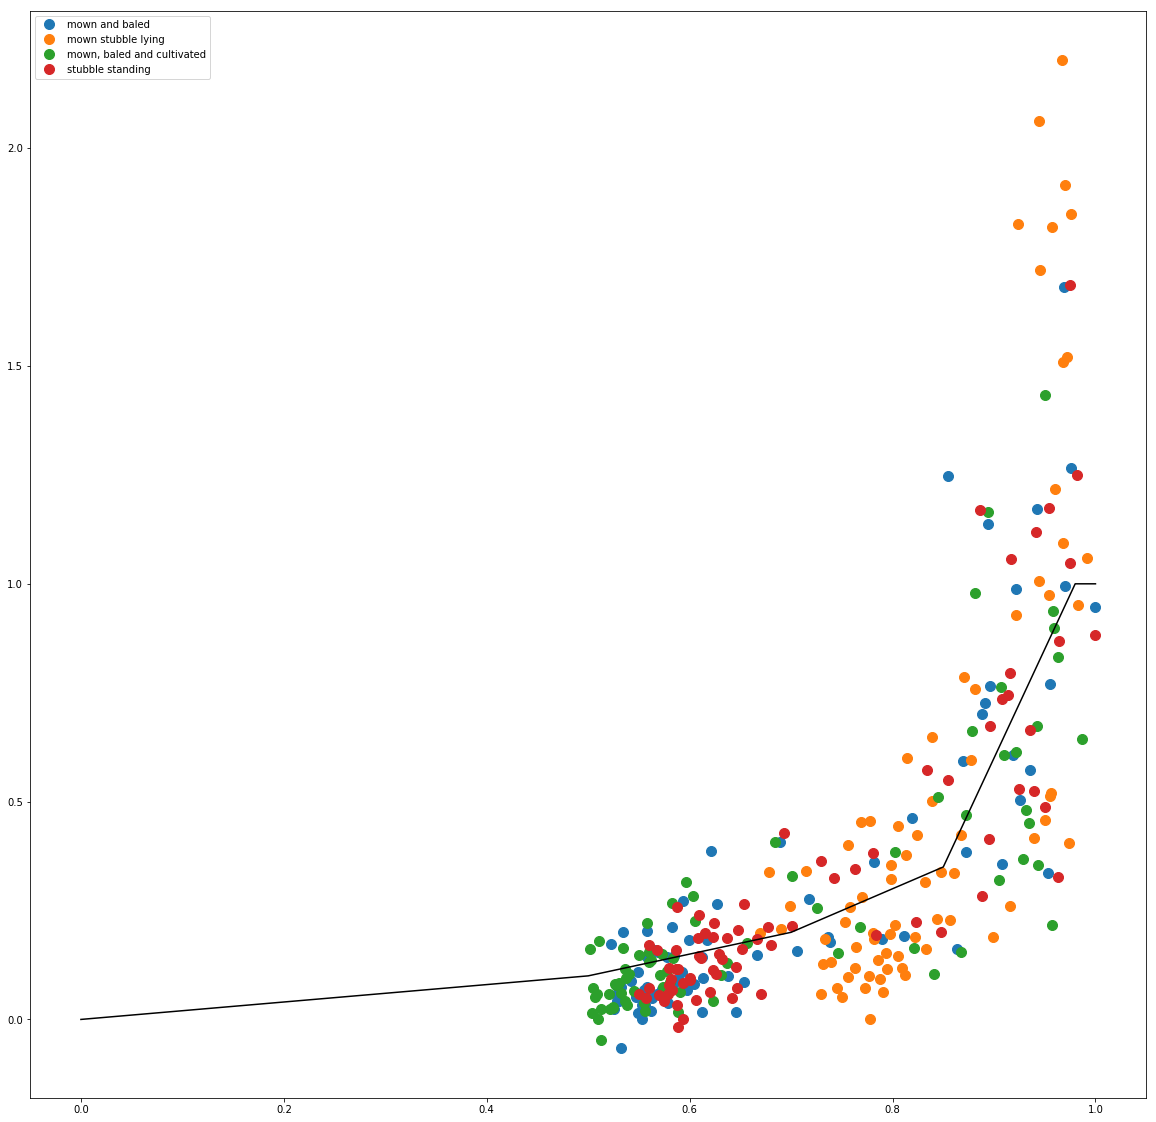

In [32]:
CleanDays = pd.DataFrame(index = SW20.index, data = DailyMet.loc[SW20.index,['Rainfall','PET']],
                         columns=['Rainfall','PET'])
#Add irrigation into rainfall for the evaporation trial
CleanDays.loc['2010-03-05','Rainfall'] += 26.6
CleanDays.loc['2010-03-08','Rainfall'] += 30.4
CleanDays.loc['2010-03-09','Rainfall'] += 100
CleanDays.loc['2010-03-12','Rainfall'] += 10

#Determine days that are clear of rainfall and substantial drainage
def DaysSinceRain(RainToday,DSRyesterday):
    if RainToday == 0:
        return DSRyesterday + 1
    else:
        if RainToday < 5:
            return 0
        else:
            if RainToday < 15:
                return -1
            else:
                if RainToday < 30:
                    return -2
                else:
                    return -3

for d in CleanDays.index:
    if d == CleanDays.index.min():
        CleanDays.loc[d,'DSR'] = 0
    else:
        CleanDays.loc[d,'DSR'] = DaysSinceRain(CleanDays.loc[d,'Rainfall'],
                                              CleanDays.loc[d - datetime.timedelta(1),'DSR'])

CleanDays.loc[:,'Test'] = (CleanDays.loc[:,'DSR']>0) & (CleanDays.loc[:,'PET']>1)

#Calculate relative water content for each plot.
LowerLimit = 0.08 #assume the same LL for all plots
AW = DailySWC.subtract(LowerLimit)
FieldCapacity = DailySWC.loc[CleanDays.loc[:,'Test'],:].max(axis=0)
AWC = FieldCapacity - LowerLimit
RelativeWC = AW.divide(AWC,axis=1)

Treatments = ResidueExptSWC.columns.get_level_values(0).drop_duplicates().values
Graph = plt.figure(figsize=(20,20))
ax = Graph.add_subplot(1,1,1)
for T in Treatments:
    plt.plot(RelativeWC.loc[CleanDays.Test,(T,1)].mean(axis=1),
             RelativeEvap.loc[CleanDays.Test,T],'o',ms=10)

Xs = [0,0.5,0.7,0.85,0.98,1.0]
Ys = [0,0.1,0.2,0.35,1.00,1.0]
    
plt.plot(Xs,Ys,'-k')
plt.legend()

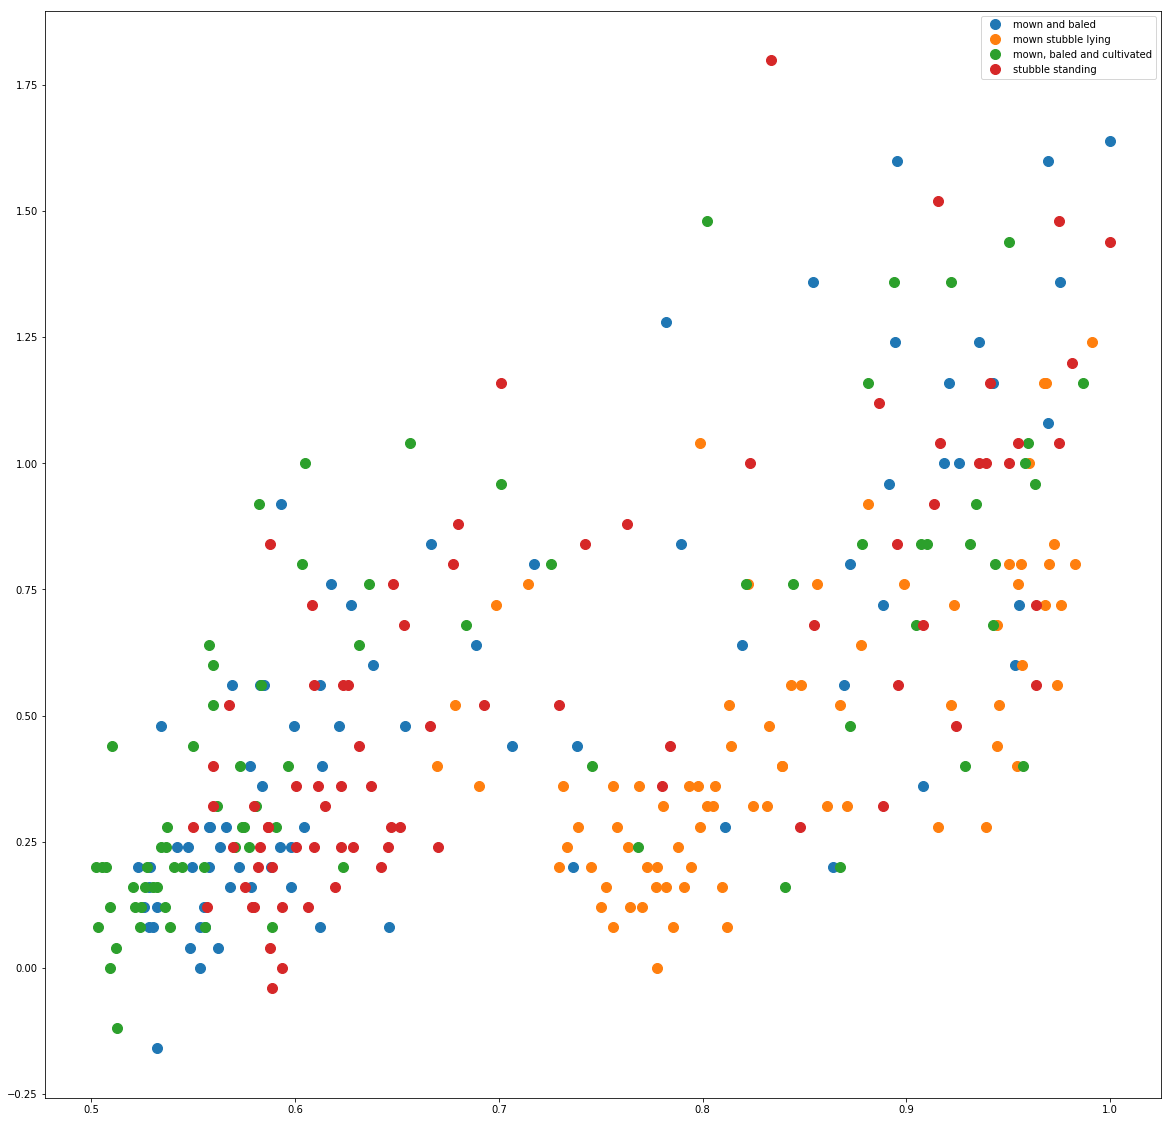

In [33]:
Treatments = ResidueExptSWC.columns.get_level_values(0).drop_duplicates().values
Graph = plt.figure(figsize=(20,20))
ax = Graph.add_subplot(1,1,1)
for T in Treatments:
    plt.plot(RelativeWC.loc[CleanDays.Test,(T,1)].mean(axis=1),
             -DeltaSW20.loc[CleanDays.Test,T],'o',ms=10)
plt.legend()